# 0008_fastai_first_steps_road_to_top_part_1

In [ ]:
#| default_exp run_kaggle_001

### jn: help other is the best way forward

**Reflection on Radek's 1st newsletter**

One way to summarize Radek's secret to success is the following: 

> No matter which stage of journey in the deep learning or any subject, when you are doing your best to help others to learn what you learnt and what you are dying to find out, and if you persist, you will be happy and successful. 

I have dreamed of such hypothesis many times when I motivated myself to share online, and Radek proved it to be solid and true! No time to waste now!

Another extremely simple but shocking secret to Radek's success is, in his words (now I can recite):

> I would suspend my disbelief and do exactly what Jeremy Howard told us to do in the lectures

What Jeremy told us to do is loud and clear, the 4 steps (watch, experiment, reproduce, apply elsewhere). More importantly, they are true and working if one holds onto it like Radek did. 

Why I am always trying to do something different? Why couldn't I just follow this great advice right from the start? I walked [a long way around it](https://twitter.com/shendusuipian/status/1587429658621988871?s=20&t=zjz1OlYRt7yJJ8HVBdsqoA) and luckily I get my sense back and move onto the second step now. 

## ht: imports - vision

### ht: imports - fastkaggle 

In [ ]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

### imports for kaggle or local

In [ ]:
if iskaggle:
    !pip install nbdev snoop

In [ ]:
if iskaggle:
    path = "../input/fastdebugutils0"
    import sys
    sys.path
    sys.path.insert(1, path)
    import utils as fu
    from utils import *
else: 
    from fastdebug.utils import *
    from fastai.vision.all import *
    import fastdebug.utils as fu

### ht: fu - whatinside, show_doc, fastlistnbs, fastnbs

In [ ]:
# whatinside(fu, dun=True) # see all functions defined in fastdebug.utils

In [ ]:
# show_doc(fastlistnbs)
# show_doc(fastnbs)

In [ ]:
# fastlistnbs("srcode")
# fastlistnbs("howto")
# fastlistnbs("doc")


In [ ]:
# fastnbs("ht: data - check")
# fastnbs("src: check_siz")

### ht: imports - upload and update mylib in kaggle

- upload my fastdebug.utils module as a dataset to kaggle, to create a dataset like one [here](https://www.kaggle.com/datasets/danielliao/fastdebugutils0)

- and in one kaggle notebook, go to the top right, under Data/Input/ find the dataset and copy file path, and run the cell below to import it

- when updating the library, go to the dataset [page](https://www.kaggle.com/datasets/danielliao/fastdebugutils0), click top right `...` and click `update version` to upload the latest version of your script

In [ ]:
# !pip install nbdev snoop

# path = "../input/fastdebugutils0"
# import sys
# sys.path
# sys.path.insert(1, path)
# import utils as fu

### ht: imports - fastkaggle - push libs to kaggle with `create_libs_datasets`

In [ ]:
# lib_path = Path('/root/kaggle_datasets') # not working
# lib_path = Path('../input/kaggle_datasets') # it's working, and created and stored locally
# username = 'danielliao'

In [ ]:
# libs = ['fastcore','timm']
# create_libs_datasets(libs,lib_path,username)

### ht: fu - git - when a commit takes too long

1. cp repo (removed the large dataset) elsewhere in your file system
2. git clone your-repo --depth 1
3. cp everything in repo except .git folder to the latest repo just downloaded
4. git push to update

### jn: how to iterate or make one step forward at at time

This is Jeremy showing us how to iterate, ie., increment learning one tiny step every time every day

In [Iterate Like a Grandmaster](https://www.kaggle.com/code/jhoward/iterate-like-a-grandmaster) I explained that when working on a Kaggle project:

> ...the focus generally should be two things:
> 
> 1. Creating an effective validation set
> 2. Iterating rapidly to find changes which improve results on the validation set.

Here I'm going to go further, showing the process I used to tackle the [Paddy Doctor](https://www.kaggle.com/competitions/paddy-disease-classification) competition, leading to four submissions in a row which all were (at the time of submission) in 1st place, each one more accurate than the last. You might be surprised to discover that the process of doing this was nearly entirely mechanistic and didn't involve any consideration of the actual data or evaluation details at all.

This notebook is the first in a series showing every step of the process. At the end of this notebook we'll have a basic submission; by the end of the series you'll see how I got to the top of the table!:

<img src="https://user-images.githubusercontent.com/346999/174389920-60d67ead-0f36-41d0-9649-e23b08720c8a.png" width="600"/>

As a special extra, I'm also opening up early a selection of "walkthru" videos that we've been preparing for the new upcoming fast.ai course. Each day I do a walkthru with fast.ai fellows and registered students, and we record those sessions. They'll all be released at the same time as the next course (probably August 2022), but I'm releasing the ones covering this competition right now! Here they are:

- [Walkthru 8](https://www.youtube.com/watch?v=-Scs4gbwWXg)
- [Walkthru 9](https://www.youtube.com/watch?v=EK5wJRzffas)
- [Walkthru 10](https://youtu.be/zhBRynq9Yvo)
- [Walkthru 11](https://youtu.be/j-zMF2VirA8)
- [Walkthru 12](https://youtu.be/GuCkpjXHdTc)
- [Walkthru 13](https://youtu.be/INrkhUGCXHg)

## ht: data_download - kaggle competition dataset

### ht: data_download - join, `kaggle.json`, `setup_comp` for local use

go to kaggle.com, go to 'account', 'api', and click 'create a new api token'

then `cp kaggle.json ~/.kaggle/`

go to the competition site and join the competition, and get the fullname of the competition for downloading the dataset

running `setup_comp(comp, install='fastai "timm>=0.6.2.dev0")` to download the dataset

First, we'll get the data. I've just created a new library called [fastkaggle](https://fastai.github.io/fastkaggle/) which has a few handy features, including getting the data for a competition correctly regardless of whether we're running on Kaggle or elsewhere. Note you'll need to first accept the competition rules and join the competition, and you'll need your kaggle API key file `kaggle.json` downloaded if you're running this somewhere other than on Kaggle. `setup_comp` is the function we use in `fastkaggle` to grab the data, and install or upgrade our needed python modules when we're running on Kaggle:

### doc: setup_comp(comp, local_folder='', install='fastai "timm>=0.6.2.dev0")

override `fastkaggle.core.setup_comp` for my use

If on kaggle, download and install required libraries to work with, and return a path linking to the dataset

If on local machine, download the dataset to the path based on local_folder if the path is not available and return the path

In [ ]:
setup_comp

<function fastkaggle.core.setup_comp(competition, install='')>

In [ ]:
show_doc(setup_comp)

---

### setup_comp

>      setup_comp (competition, install='')

Get a path to data for `competition`, downloading it if needed

```python
@snoop
def setup_comp(competition, local_folder='', install=''):
    "Get a path to data for `competition`, downloading it if needed"
    if iskaggle:
        if install:
            os.system(f'pip install -Uqq {install}')
        return Path('../input')/competition
    else:
        path = Path(local_folder + competition)
        api = import_kaggle()
        if not path.exists():
            import zipfile
#             pp(doc_sig(api.competition_download_cli))
#             return
            api.competition_download_cli(str(competition), path=path)
            zipfile.ZipFile(f'{local_folder + competition}.zip').extractall(str(local_folder + competition))
        return path
# File:      ~/mambaforge/lib/python3.9/site-packages/fastkaggle/core.py
# Type:      function
```

In [ ]:
show_doc(fastkaggle.core.setup_comp)

---

### setup_comp

>      setup_comp (competition, install='')

Get a path to data for `competition`, downloading it if needed

In [ ]:
src(fastkaggle.core.setup_comp)

def setup_comp(competition, install=''):
    "Get a path to data for `competition`, downloading it if needed"
    if iskaggle:
        if install:
            os.system(f'pip install -Uqq {install}')
        return Path('../input')/competition
    else:
        path = Path(competition)
        api = import_kaggle()
        if not path.exists():
            import zipfile
            api.competition_download_cli(str(competition))
            zipfile.ZipFile(f'{competition}.zip').extractall(str(competition))
        return path



### ht: fu - debug every srcline without breaking

withe magic of `return` we can use `@snoop`, `pp`, `doc_sig`, `chk`, `src` to do debug anything we want

In [ ]:
src(chk)

def chk(obj):
    "return obj's type, length and type if available"
    tp = type(obj)
    length = obj.__len__() if hasattr(obj, '__len__') else "no length"
    shape = obj.shape if hasattr(obj, 'shape') else "no shape"
    return tp, length, shape



### ht: fu - (de)activate snoop without commenting out using `snoopon()` and `snoopoff()`  

### src: setup_compsetup_comp(comp, local_folder='', install='fastai "timm>=0.6.2.dev0")

In [ ]:
snoopon()

In [ ]:
# @snoop
# def setup_comp(competition, local_folder='', install=''):
#     "Get a path to data for `competition`, downloading it if needed"
#     if iskaggle:
#         if install:
#             os.system(f'pip install -Uqq {install}')
#         return Path('../input')/competition
#     else:
#         path = Path(local_folder + competition)
#         api = import_kaggle()
#         if not path.exists():
#             import zipfile
# #             pp(doc_sig(api.competition_download_cli))
# #             return
#             api.competition_download_cli(str(competition), path=path)
#             zipfile.ZipFile(f'{local_folder + competition}.zip').extractall(str(local_folder + competition))
#         return path
# # File:      ~/mambaforge/lib/python3.9/site-packages/fastkaggle/core.py
# # Type:      function

In [ ]:
comp = 'paddy-disease-classification' # https://www.kaggle.com/competitions/paddy-disease-classification/submissions
# local = "/Users/Natsume/Documents/"
# path = setup_comp(comp, local_folder=local, install='fastai "timm>=0.6.2.dev0"')
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

In [ ]:
snoopoff()

In [ ]:
path.ls()

(#4) [Path('paddy-disease-classification/test_images'),Path('paddy-disease-classification/train.csv'),Path('paddy-disease-classification/train_images'),Path('paddy-disease-classification/sample_submission.csv')]

### ht: data_prep reproducibility in training a model

Now we can import the stuff we'll need from fastai, set a seed (for reproducibility -- just for the purposes of making this notebook easier to write; I don't recommend doing that in your own analysis however) and check what's in the data:

In [ ]:
# hts

In [ ]:
set_seed(42)

## ht: data - access dataset

### ht: data_access - map subfolders content with `check_subfolders_img`

use `path.ls()` and `check_subfolders_img(path)` to see what inside each subfolders

In [ ]:
path.ls()

(#4) [Path('paddy-disease-classification/test_images'),Path('paddy-disease-classification/train.csv'),Path('paddy-disease-classification/train_images'),Path('paddy-disease-classification/sample_submission.csv')]

### src: check_subfolders_img(path, db=False)

In [ ]:
#| export utils 
from fastai.data.transforms import image_extensions

In [ ]:
#| export utils
# @snoop
def check_subfolders_img(path, db=False):
    from pathlib import Path
    for entry in path.iterdir():
        if entry.is_file():
            print(f'{str(entry.absolute())}')
    addup = 0
    for entry in path.iterdir():
        if entry.is_dir() and not entry.name.startswith(".") and len(entry.ls(file_exts=image_extensions)) > 5:
            addup += len(entry.ls(file_exts=image_extensions))
            print(f'{str(entry.parent.absolute())}: {len(entry.ls(file_exts=image_extensions))}  {entry.name}')
#             print(entry.name, f': {len(entry.ls(file_exts=[".jpg", ".png", ".jpeg", ".JPG", ".jpg!d"]))}') # how to include both png and jpg
            if db:
                for e in entry.ls(): # check any image file which has a different suffix from those above
                    if e.is_file() and not e.name.startswith(".") and e.suffix not in image_extensions and e.suffix not in [".ipynb", ".py"]:
    #                 if e.suffix not in [".jpg", ".png", ".jpeg", ".JPG", ".jpg!d"]:
                        pp(e.suffix, e)
                        try:
                            pp(Image.open(e).width)
                        except:
                            print(f"{e} can't be opened")
    #                     pp(Image.open(e).width if e.suffix in image_extensions)
        elif entry.is_dir() and not entry.name.startswith("."): 
#             with snoop:
            check_subfolders_img(entry)
    print(f"addup num: {addup}")

In [ ]:
check_subfolders_img(path)

/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/paddy-disease-classification/train.csv
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/paddy-disease-classification/sample_submission.csv
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/paddy-disease-classification: 3469  test_images
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/paddy-disease-classification/train_images: 1442  dead_heart
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/paddy-disease-classification/train_images: 337  bacterial_panicle_blight
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/paddy-disease-classification/train_images: 479  bacterial_leaf_blight
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/paddy-disease-classification/train_images: 965  brown_spot
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/paddy-disease-classification/train_images: 1594  hispa
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/paddy-disease-classification/train_images

### ht: data_access - extract all images for test and train with `get_image_files`

In [ ]:
test_files = get_image_files(path/"test_images")
train_files = get_image_files(path/"train_images")

In [ ]:
test_files
train_files

(#3469) [Path('paddy-disease-classification/test_images/202919.jpg'),Path('paddy-disease-classification/test_images/200868.jpg'),Path('paddy-disease-classification/test_images/200698.jpg'),Path('paddy-disease-classification/test_images/200840.jpg'),Path('paddy-disease-classification/test_images/201586.jpg'),Path('paddy-disease-classification/test_images/203391.jpg'),Path('paddy-disease-classification/test_images/202931.jpg'),Path('paddy-disease-classification/test_images/202925.jpg'),Path('paddy-disease-classification/test_images/203385.jpg'),Path('paddy-disease-classification/test_images/200854.jpg')...]

(#10407) [Path('paddy-disease-classification/train_images/dead_heart/110369.jpg'),Path('paddy-disease-classification/train_images/dead_heart/105002.jpg'),Path('paddy-disease-classification/train_images/dead_heart/106279.jpg'),Path('paddy-disease-classification/train_images/dead_heart/108254.jpg'),Path('paddy-disease-classification/train_images/dead_heart/104308.jpg'),Path('paddy-disease-classification/train_images/dead_heart/107629.jpg'),Path('paddy-disease-classification/train_images/dead_heart/110355.jpg'),Path('paddy-disease-classification/train_images/dead_heart/100146.jpg'),Path('paddy-disease-classification/train_images/dead_heart/103329.jpg'),Path('paddy-disease-classification/train_images/dead_heart/105980.jpg')...]

In [ ]:
# fastnbs("src: get_image_files")

...and take a look at one:

### ht: data_access - display an image from test_files or train_files with `randomdisplay`

use `randomdisplay(path, size, db=False)` to display images from a folder or a L list of images such as `test_files` or `train_files`

### src: randomdisplay(path, size, db=False)

display a random images from a L list (eg., test_files, train_files) of image files or from a path/folder of images.\
    the image filename is printed as well

In [ ]:
import pathlib
type(path) == pathlib.PosixPath
type(train_files) == L

True

True

In [ ]:
snoopon()

In [ ]:
#| export utils
# @snoop
def randomdisplay(path, size=128, db=False):
    "display a random images from a L list (eg., test_files, train_files) of image files or from a path/folder of images.\
    the image filename is printed as well"
# https://www.geeksforgeeks.org/python-random-module/
    import random
    import pathlib
    from fastai.vision.all import PILImage
    if type(path) == pathlib.PosixPath:
        rand = random.randint(0,len(path.ls())-1) 
        file = path.ls()[rand]
    elif type(path) == L:
        rand = random.randint(0,len(path)-1) 
        file = path[rand]
    im = PILImage.create(file)
    if db: pp(im.width, im.height, file)
    pp(file)
    return im.to_thumb(size)

15:54:56.56 LOG:
15:54:56.70 .... file = Path('paddy-disease-classification/test_images/201216.jpg')


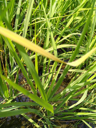

15:54:56.70 LOG:
15:54:56.70 .... file = Path('paddy-disease-classification/train_images/bacterial_leaf_blight/104518.jpg')


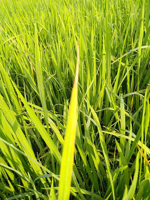

15:54:56.72 LOG:
15:54:56.72 .... file = Path('paddy-disease-classification/train_images/dead_heart/100966.jpg')


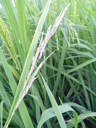

In [ ]:
randomdisplay(test_files, 128)
randomdisplay(train_files, 200)
randomdisplay(path/"train_images/dead_heart", 128)

In [ ]:
snoopoff()

### ht: data_prep - remove images that fail to open with `remove_failed(path)`

#### why must remove failed images

images failed to open must be removed, otherwise it will cause errors during training.

In [ ]:
# fastnbs("remove_failed")
# verify_images??

In [ ]:
remove_failed(path)

before running remove_failed:
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/paddy-disease-classification/train.csv
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/paddy-disease-classification/sample_submission.csv
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/paddy-disease-classification: 3469  test_images
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/paddy-disease-classification/train_images: 1442  dead_heart
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/paddy-disease-classification/train_images: 337  bacterial_panicle_blight
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/paddy-disease-classification/train_images: 479  bacterial_leaf_blight
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/paddy-disease-classification/train_images: 965  brown_spot
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/paddy-disease-classification/train_images: 1594  hispa
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/paddy-disea

### ht: data_prep - describe sizes of all images with `check_sizes_img`

Looks like the images might be 480x640 -- let's check all their sizes. This is faster if we do it in parallel, so we'll use fastcore's `parallel` for this:

In [ ]:
PILImage

fastai.vision.core.PILImage

### src: check_sizes_img(files)


In [ ]:
#| export utils
def f(o, sz=None): 
    im = None
    if sz and PILImage.create(o).size == sz:
        im = PILImage.create(o).to_thumb(500)
    return PILImage.create(o).size, im

In [ ]:
# from fastcore.parallel import parallel
# doc(parallel)

In [ ]:
#| export utils 
from fastcore.meta import delegates

In [ ]:
#| export utils
# @snoop
@delegates(f)
def check_sizes_img(files, **kwargs):
    "use fastcore.parallel to quickly find out the different sizes of all images and their occurences. \
    output images with specific sizes if specified in `sz`"
    from fastcore.parallel import parallel
    res = parallel(f, files, n_workers=8, **kwargs) # add sz as a keyword to parallel
    sizes = [size for size, im in res]
    imgs = [im for size, im in res if im != None]
    pp(pd.Series(sizes).value_counts())  
    pp(imgs)
    if len(imgs):
        for im in imgs:
            im.to_thumb(125).show()
    return imgs

In [ ]:
check_sizes_img(train_files)

[]

In [ ]:
imgs = check_sizes_img(test_files, sz = (640, 480))

### qt: how to display a list of images?

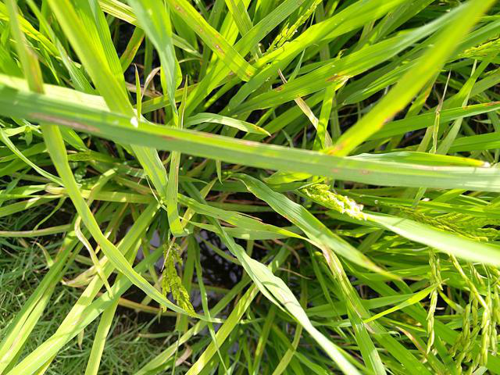

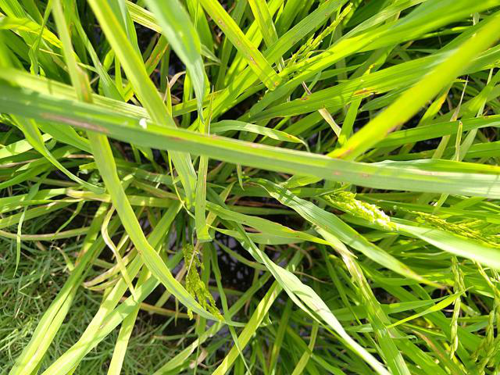

In [ ]:
imgs[0] 
imgs[1]


### ht: data_loaders - create a dataloader from a folder with `ImageDataLoaders.from_folder`

A dataloader prepares training and validation sets, transformations to each image, and batch transformations to each batch of images

#### qt: why must all images have the same dimensions? how to resolve this problem?

They're nearly all the same size, except for a few. Because of those few, however, we'll need to make sure we always resize each image to common dimensions first, otherwise fastai won't be able to create batches. 

For now, we'll just squish them to 480x480 images, and then once they're in batches we do a random resized crop down to a smaller size, along with the other default fastai augmentations provided by `aug_transforms`. 

#### qt: why should we start with small resized images
We'll start out with small resized images, since we want to be able to iterate quickly:

In [ ]:
# fastnbs("src: ImageDataLoaders")
# ImageDataLoaders??

### doc: ImageDataLoaders.from_folder

To create a DataLoader obj from a folder, and a dataloader prepares functions for splitting training and validation sets, extracting images and labels, each item transformations, and batch transformations.

eg., give it `trn_path` (folder has subfolders like train, test or even valid), `valid_pct` (split a portion from train to create validation set), `seed` (set a seed for reproducibility), `item_tfms` (do transforms to each item), and `batch_tfms` (do transformations on batches)

```python
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls.show_batch(max_n=6)
```

```python
@classmethod
@delegates(DataLoaders.from_dblock)
def from_folder(cls:ImageDataLoaders, path, train='train', valid='valid', valid_pct=None, seed=None, vocab=None, item_tfms=None,
                batch_tfms=None, img_cls=PILImage, **kwargs):
    "Create from imagenet style dataset in `path` with `train` and `valid` subfolders (or provide `valid_pct`)"
    # get the splitter function to split training and validation sets
    splitter = GrandparentSplitter(train_name=train, valid_name=valid) if valid_pct is None else RandomSplitter(valid_pct, seed=seed)
    # get the function to extract image files from using get_image_files in different spices
    get_items = get_image_files if valid_pct else partial(get_image_files, folders=[train, valid])
    # create a DataBlock object to organise all the data processing functions or callbacks
    dblock = DataBlock(blocks=(ImageBlock(img_cls), CategoryBlock(vocab=vocab)),
                       get_items=get_items,
                       splitter=splitter,
                       get_y=parent_label,
                       item_tfms=item_tfms,
                       batch_tfms=batch_tfms)
    # return a dataloaders created from the given DataBlock object above calling DataBlock.dataloaders
    return cls.from_dblock(dblock, path, path=path, **kwargs)
# File:      ~/mambaforge/lib/python3.9/site-packages/fastai/vision/data.py
# Type:      method
```

In [ ]:
show_doc(ImageDataLoaders.from_folder)

---

[source](https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### ImageDataLoaders.from_folder

>      ImageDataLoaders.from_folder (path, train='train', valid='valid',
>                                    valid_pct=None, seed=None, vocab=None,
>                                    item_tfms=None, batch_tfms=None,
>                                    img_cls=<class
>                                    'fastai.vision.core.PILImage'>, bs:int=64,
>                                    val_bs:int=None, shuffle:bool=True,
>                                    device=None)

Create from imagenet style dataset in `path` with `train` and `valid` subfolders (or provide `valid_pct`)

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| path | str \| Path | . | Path to put in `DataLoaders` |
| train | str | train |  |
| valid | str | valid |  |
| valid_pct | NoneType | None |  |
| seed | NoneType | None |  |
| vocab | NoneType | None |  |
| item_tfms | NoneType | None |  |
| batch_tfms | NoneType | None |  |
| img_cls | BypassNewMeta | PILImage |  |
| bs | int | 64 | Size of batch |
| val_bs | int | None | Size of batch for validation `DataLoader` |
| shuffle | bool | True | Whether to shuffle data |
| device | NoneType | None | Device to put `DataLoaders` |

### src: ImageDataLoaders.from_folder

In [ ]:
snoopon()

In [ ]:
from __future__ import annotations # to ensure path:str|Path='.' can work

In [ ]:
class ImageDataLoaders(DataLoaders):
    "Basic wrapper around several `DataLoader`s with factory methods for computer vision problems"
    @classmethod
    @snoop
    @delegates(DataLoaders.from_dblock)
    def from_folder(cls, path, train='train', valid='valid', valid_pct=None, seed=None, vocab=None, item_tfms=None,
                    batch_tfms=None, **kwargs):
        "Create from imagenet style dataset in `path` with `train` and `valid` subfolders (or provide `valid_pct`)"
        splitter = GrandparentSplitter(train_name=train, valid_name=valid) if valid_pct is None else RandomSplitter(valid_pct, seed=seed)
        get_items = get_image_files if valid_pct else partial(get_image_files, folders=[train, valid])
        dblock = DataBlock(blocks=(ImageBlock, CategoryBlock(vocab=vocab)),
                           get_items=get_items,
                           splitter=splitter,
                           get_y=parent_label,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        pp(doc_sig(cls.from_dblock))
        pp(inspect.getsource(cls.from_dblock))
        return cls.from_dblock(dblock, path, path=path, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_path_func(cls, path, fnames, label_func, valid_pct=0.2, seed=None, item_tfms=None, batch_tfms=None, **kwargs):
        "Create from list of `fnames` in `path`s with `label_func`"
        dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                           splitter=RandomSplitter(valid_pct, seed=seed),
                           get_y=label_func,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, fnames, path=path, **kwargs)

    @classmethod
    def from_name_func(cls,
        path:str|Path, # Set the default path to a directory that a `Learner` can use to save files like models
        fnames:list, # A list of `os.Pathlike`'s to individual image files
        label_func:callable, # A function that receives a string (the file name) and outputs a label
        **kwargs
    ) -> DataLoaders:
        "Create from the name attrs of `fnames` in `path`s with `label_func`"
        if sys.platform == 'win32' and isinstance(label_func, types.LambdaType) and label_func.__name__ == '<lambda>':
            # https://medium.com/@jwnx/multiprocessing-serialization-in-python-with-pickle-9844f6fa1812
            raise ValueError("label_func couldn't be lambda function on Windows")
        f = using_attr(label_func, 'name')
        return cls.from_path_func(path, fnames, f, **kwargs)

    @classmethod
    def from_path_re(cls, path, fnames, pat, **kwargs):
        "Create from list of `fnames` in `path`s with re expression `pat`"
        return cls.from_path_func(path, fnames, RegexLabeller(pat), **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_name_re(cls, path, fnames, pat, **kwargs):
        "Create from the name attrs of `fnames` in `path`s with re expression `pat`"
        return cls.from_name_func(path, fnames, RegexLabeller(pat), **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_df(cls, df, path='.', valid_pct=0.2, seed=None, fn_col=0, folder=None, suff='', label_col=1, label_delim=None,
                y_block=None, valid_col=None, item_tfms=None, batch_tfms=None, **kwargs):
        "Create from `df` using `fn_col` and `label_col`"
        pref = f'{Path(path) if folder is None else Path(path)/folder}{os.path.sep}'
        if y_block is None:
            is_multi = (is_listy(label_col) and len(label_col) > 1) or label_delim is not None
            y_block = MultiCategoryBlock if is_multi else CategoryBlock
        splitter = RandomSplitter(valid_pct, seed=seed) if valid_col is None else ColSplitter(valid_col)
        dblock = DataBlock(blocks=(ImageBlock, y_block),
                           get_x=ColReader(fn_col, pref=pref, suff=suff),
                           get_y=ColReader(label_col, label_delim=label_delim),
                           splitter=splitter,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, df, path=path, **kwargs)

    @classmethod
    def from_csv(cls, path, csv_fname='labels.csv', header='infer', delimiter=None, **kwargs):
        "Create from `path/csv_fname` using `fn_col` and `label_col`"
        df = pd.read_csv(Path(path)/csv_fname, header=header, delimiter=delimiter)
        return cls.from_df(df, path=path, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_lists(cls, path, fnames, labels, valid_pct=0.2, seed:int=None, y_block=None, item_tfms=None, batch_tfms=None,
                   **kwargs):
        "Create from list of `fnames` and `labels` in `path`"
        if y_block is None:
            y_block = MultiCategoryBlock if is_listy(labels[0]) and len(labels[0]) > 1 else (
                RegressionBlock if isinstance(labels[0], float) else CategoryBlock)
        dblock = DataBlock.from_columns(blocks=(ImageBlock, y_block),
                           splitter=RandomSplitter(valid_pct, seed=seed),
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, (fnames, labels), path=path, **kwargs)
# File:           ~/mambaforge/lib/python3.9/site-packages/fastai/vision/data.py
# Type:           type
# Subclasses:     

In [ ]:
trn_path = path/"train_images"
trn_path.ls()

(#10) [Path('paddy-disease-classification/train_images/dead_heart'),Path('paddy-disease-classification/train_images/bacterial_panicle_blight'),Path('paddy-disease-classification/train_images/bacterial_leaf_blight'),Path('paddy-disease-classification/train_images/brown_spot'),Path('paddy-disease-classification/train_images/hispa'),Path('paddy-disease-classification/train_images/downy_mildew'),Path('paddy-disease-classification/train_images/blast'),Path('paddy-disease-classification/train_images/normal'),Path('paddy-disease-classification/train_images/bacterial_leaf_streak'),Path('paddy-disease-classification/train_images/tungro')]

In [ ]:
train_files

(#10407) [Path('paddy-disease-classification/train_images/dead_heart/110369.jpg'),Path('paddy-disease-classification/train_images/dead_heart/105002.jpg'),Path('paddy-disease-classification/train_images/dead_heart/106279.jpg'),Path('paddy-disease-classification/train_images/dead_heart/108254.jpg'),Path('paddy-disease-classification/train_images/dead_heart/104308.jpg'),Path('paddy-disease-classification/train_images/dead_heart/107629.jpg'),Path('paddy-disease-classification/train_images/dead_heart/110355.jpg'),Path('paddy-disease-classification/train_images/dead_heart/100146.jpg'),Path('paddy-disease-classification/train_images/dead_heart/103329.jpg'),Path('paddy-disease-classification/train_images/dead_heart/105980.jpg')...]

In [ ]:
# fastnbs("get_image_files")

In [ ]:
# 'paddy-disease-classification/train_images/dead_heart/110369.jpg'.split('/')[-2]
# parent_label('paddy-disease-classification/train_images/dead_heart/110369.jpg')

In [ ]:
# check_subfolders_img(path/"train_images")

### ht: data_access - select a subset from each subfolder with `get_image_files_subset`

To experiment the code efficiently on a local machine without a gpu, requies to use a smaller dataset or a subset of a large dataset. As I am experimenting on Jeremy's Paddy competition [notebooks](https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1?scriptVersionId=98743415&cellId=18), I need to find a way to shrink the dataset which is 1 GB in size. 

At first, I tried to shrink the training set and validation set after I got a dataloader `dls`. I managed to shrink the size by `dls.train_ds.items = dls.train_ds.items[:1000]` and validation set respectively. However, I can't run `learn.lr_find` nor `learn.fit` without error. It seems `dls` still uses some meta data produced when creating the `dls` from the full dataset.

Instead of tweaking the source code related to `Datasets` and `DataLoaders` to take care of the meta data, it should be easier to shrink the dataset before creating the `dls`. 

If using `ImageDataLoaders.from_folder`, from its signature we can tell that to have a shrinked dataset, we have to create a parent folder with 10 diseaese folders which are all shrinked in size. I don't have any code template to tweak in order to make it work.

If using `ImageDataLoaders.from_path_func`, based on its signature, instead of a parent folder of folders (a shrinked version), I just need to provide a L list of image files which is a shrinked version of a full dataset. This approach seems more straightforward with a little tweaking on `get_image_files`. 

In [ ]:
snoopon()

In [ ]:
def _get_files_subset(p, # path
               fs, # list of filenames 
               extensions=None,
               ratio=0.1):
    "get the fullnames for the list of filenames of a path"
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res[:int(len(res)*ratio)]

In [ ]:
@delegates(_get_files_subset)
def get_files_subset(path, recurse=True, folders=None, followlinks=True, **kwargs):
    "Get all the files in `path` with optional `extensions`, optionally with `recurse`, only in `folders`, if specified."
    path = Path(path)
    folders=L(folders)
    extensions = kwargs['extensions']
    ratio = kwargs['ratio']
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path, followlinks=followlinks)): # returns (dirpath, dirnames, filenames)
            if len(folders) !=0 and i==0: d[:] = [o for o in d if o in folders]
            else:                         d[:] = [o for o in d if not o.startswith('.')]
            if len(folders) !=0 and i==0 and '.' not in folders: continue
            res += _get_files(p, f, extensions, ratio=ratio)
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        res = _get_files_subset(path, f, extensions, ratio=ratio)
    return L(res)
# File:      ~/mambaforge/lib/python3.9/site-packages/fastai/data/transforms.py
# Type:      function

In [ ]:
get_files

<function __main__.get_files(path, recurse=True, folders=None, followlinks=True, *, extensions=None, ratio=0.1)>

In [ ]:
@delegates(get_files)
def get_image_files_subset(path, ratio, **kwargs):
    "Get image files in `path` recursively, only in `folders`, if specified."
    return get_files_subset(path, ratio=ratio, extensions=image_extensions, **kwargs)
# File:      ~/mambaforge/lib/python3.9/site-packages/fastai/data/transforms.py
# Type:      function

In [ ]:
get_image_files_subset

<function __main__.get_image_files_subset(path, ratio, *, recurse=True, folders=None, followlinks=True, extensions=None)>

In [ ]:
train_reduced = get_image_files_subset(path/"train_images", 0.1)
train_reduced

(#1036) [Path('paddy-disease-classification/train_images/dead_heart/110369.jpg'),Path('paddy-disease-classification/train_images/dead_heart/105002.jpg'),Path('paddy-disease-classification/train_images/dead_heart/106279.jpg'),Path('paddy-disease-classification/train_images/dead_heart/108254.jpg'),Path('paddy-disease-classification/train_images/dead_heart/104308.jpg'),Path('paddy-disease-classification/train_images/dead_heart/107629.jpg'),Path('paddy-disease-classification/train_images/dead_heart/110355.jpg'),Path('paddy-disease-classification/train_images/dead_heart/100146.jpg'),Path('paddy-disease-classification/train_images/dead_heart/103329.jpg'),Path('paddy-disease-classification/train_images/dead_heart/105980.jpg')...]

In [ ]:
len(train_files)
len(train_reduced)
train_reduced[100]
train_reduced[200]
train_reduced[300]

10407

1036

Path('paddy-disease-classification/train_images/dead_heart/101271.jpg')

Path('paddy-disease-classification/train_images/bacterial_leaf_blight/101649.jpg')

Path('paddy-disease-classification/train_images/brown_spot/100780.jpg')

In [ ]:
snoopoff()

(#829) [(PILImage mode=RGB size=480x640, TensorCategory(7)),(PILImage mode=RGB size=480x640, TensorCategory(7)),(PILImage mode=RGB size=480x640, TensorCategory(7)),(PILImage mode=RGB size=480x640, TensorCategory(6)),(PILImage mode=RGB size=480x640, TensorCategory(5)),(PILImage mode=RGB size=480x640, TensorCategory(0)),(PILImage mode=RGB size=480x640, TensorCategory(5)),(PILImage mode=RGB size=480x640, TensorCategory(3)),(PILImage mode=RGB size=480x640, TensorCategory(3)),(PILImage mode=RGB size=480x640, TensorCategory(9))...]

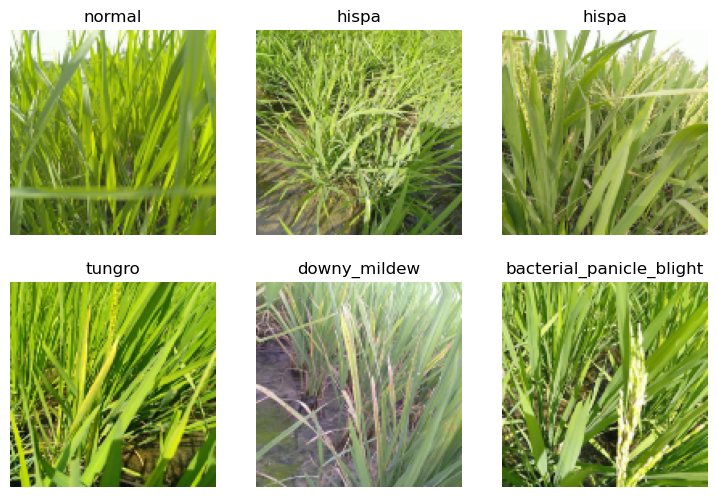

In [ ]:
dls = ImageDataLoaders.from_path_func(".", train_reduced, valid_pct=0.2, seed=42,
#     label_func = lambda x: str(x).split('/')[-2],
    label_func = parent_label,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls.show_batch(max_n=6)
dls.train_ds

In [ ]:
# dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
#     item_tfms=Resize(480, method='squish'),
#     batch_tfms=aug_transforms(size=128, min_scale=0.75))

# dls.show_batch(max_n=6)

In [ ]:
snoopoff()

### ht: data_loaders - apply transformations to each image with `item_tfms = Resize(480, method='squish')`

Besides gathering all the images, dataloaders need to prepare transformations eg., resize to each image. This is done with `item_tfms = Resize(480, method='squish')`

### ht: data_loaders - apply image augmentations to each batch of data with `batch_tfms = aug_transforms`

After transformations done to each image, we can apply image augmentations like flip, rotate, zoom, wrap, lighting to each batch of images

### doc: aug_transforms(size=128, min_scale=0.75)

to return a list of image augmentations (transformations) for doing custom flip, rotate, zoom, warp, lighting

In [ ]:
# The official doc is easy to understand and the explanation to each arg is very helpful.
show_doc(aug_transforms)

---

[source](https://github.com/fastai/fastai/blob/master/fastai/vision/augment.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### aug_transforms

>      aug_transforms (mult:float=1.0, do_flip:bool=True, flip_vert:bool=False,
>                      max_rotate:float=10.0, min_zoom:float=1.0,
>                      max_zoom:float=1.1, max_lighting:float=0.2,
>                      max_warp:float=0.2, p_affine:float=0.75,
>                      p_lighting:float=0.75, xtra_tfms:list=None,
>                      size:Union[int,tuple]=None, mode:str='bilinear',
>                      pad_mode='reflection', align_corners=True, batch=False,
>                      min_scale=1.0)

Utility func to easily create a list of flip, rotate, zoom, warp, lighting transforms.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| mult | float | 1.0 | Multiplication applying to `max_rotate`,`max_lighting`,`max_warp` |
| do_flip | bool | True | Random flipping |
| flip_vert | bool | False | Flip vertically |
| max_rotate | float | 10.0 | Maximum degree of rotation |
| min_zoom | float | 1.0 | Minimum zoom |
| max_zoom | float | 1.1 | Maximum zoom |
| max_lighting | float | 0.2 | Maximum scale of changing brightness |
| max_warp | float | 0.2 | Maximum value of changing warp per |
| p_affine | float | 0.75 | Probability of applying affine transformation |
| p_lighting | float | 0.75 | Probability of changing brightnest and contrast |
| xtra_tfms | list | None | Custom Transformations |
| size | int \| tuple | None | Output size, duplicated if one value is specified |
| mode | str | bilinear | PyTorch `F.grid_sample` interpolation |
| pad_mode | str | reflection | A `PadMode` |
| align_corners | bool | True | PyTorch `F.grid_sample` align_corners |
| batch | bool | False | Apply identical transformation to entire batch |
| min_scale | float | 1.0 | Minimum scale of the crop, in relation to image area |

In [ ]:
src(aug_transforms)

def aug_transforms(
    mult:float=1.0, # Multiplication applying to `max_rotate`,`max_lighting`,`max_warp`
    do_flip:bool=True, # Random flipping
    flip_vert:bool=False, # Flip vertically
    max_rotate:float=10., # Maximum degree of rotation
    min_zoom:float=1., # Minimum zoom 
    max_zoom:float=1.1, # Maximum zoom 
    max_lighting:float=0.2, # Maximum scale of changing brightness 
    max_warp:float=0.2, # Maximum value of changing warp per
    p_affine:float=0.75, # Probability of applying affine transformation
    p_lighting:float=0.75, # Probability of changing brightnest and contrast 
    xtra_tfms:list=None, # Custom Transformations
    size:int|tuple=None, # Output size, duplicated if one value is specified
    mode:str='bilinear', # PyTorch `F.grid_sample` interpolation
    pad_mode=PadMode.Reflection, # A `PadMode`
    align_corners=True, # PyTorch `F.grid_sample` align_corners
    batch=False, # Apply identical transformation to entire batch
    min_scale=1. # Minim

### src: aug_transforms(size=128, min_scale=0.75)

In [ ]:
snoopon()

In [ ]:
# @snoop
def aug_transforms(
    mult:float=1.0, # Multiplication applying to `max_rotate`,`max_lighting`,`max_warp`
    do_flip:bool=True, # Random flipping
    flip_vert:bool=False, # Flip vertically
    max_rotate:float=10., # Maximum degree of rotation
    min_zoom:float=1., # Minimum zoom 
    max_zoom:float=1.1, # Maximum zoom 
    max_lighting:float=0.2, # Maximum scale of changing brightness 
    max_warp:float=0.2, # Maximum value of changing warp per
    p_affine:float=0.75, # Probability of applying affine transformation
    p_lighting:float=0.75, # Probability of changing brightnest and contrast 
    xtra_tfms:list=None, # Custom Transformations
    size:int|tuple=None, # Output size, duplicated if one value is specified
    mode:str='bilinear', # PyTorch `F.grid_sample` interpolation
    pad_mode=PadMode.Reflection, # A `PadMode`
    align_corners=True, # PyTorch `F.grid_sample` align_corners
    batch=False, # Apply identical transformation to entire batch
    min_scale=1. # Minimum scale of the crop, in relation to image area
):
    "Utility func to easily create a list of flip, rotate, zoom, warp, lighting transforms."
    res,tkw = [],dict(size=size if min_scale==1. else None, mode=mode, pad_mode=pad_mode, batch=batch, align_corners=align_corners)
    max_rotate,max_lighting,max_warp = array([max_rotate,max_lighting,max_warp])*mult
    if do_flip: res.append(Dihedral(p=0.5, **tkw) if flip_vert else Flip(p=0.5, **tkw))
    if max_warp:   res.append(Warp(magnitude=max_warp, p=p_affine, **tkw))
    if max_rotate: res.append(Rotate(max_deg=max_rotate, p=p_affine, **tkw))
    if min_zoom<1 or max_zoom>1: res.append(Zoom(min_zoom=min_zoom, max_zoom=max_zoom, p=p_affine, **tkw))
    if max_lighting:
        res.append(Brightness(max_lighting=max_lighting, p=p_lighting, batch=batch))
        res.append(Contrast(max_lighting=max_lighting, p=p_lighting, batch=batch))
    if min_scale!=1.: xtra_tfms = RandomResizedCropGPU(size, min_scale=min_scale, ratio=(1,1)) + L(xtra_tfms)
#     pp(res, L(xtra_tfms), doc_sig(setup_aug_tfms))
    return setup_aug_tfms(res + L(xtra_tfms))
# File:      ~/mambaforge/lib/python3.9/site-packages/fastai/vision/augment.py
# Type:      function

In [ ]:
aug_transforms(size=128, min_scale=0.75)

16:07:25.22 LOG:
16:07:25.22 .... res = [Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}:
16:07:25.22            encodes: (TensorImage,object) -> encodes
16:07:25.22            (TensorMask,object) -> encodes
16:07:25.22            (TensorBBox,object) -> encodes
16:07:25.22            (TensorPoint,object) -> encodes
16:07:25.22            decodes: ,
16:07:25.22             Warp -- {'magnitude': 0.2, 'p': 1.0, 'draw_x': None, 'draw_y': None, 'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'batch': False, 'align_corners': True, 'mode_mask': 'nearest'}:
16:07:25.22            encodes: (TensorImage,object) -> encodes
16:07:25.22            (TensorMask,object) -> encodes
16:07:25.22            (TensorBBox,object) -> encodes
16:07:25.22            (TensorPoint,object) -> encodes
16:07:25.22            decodes: ,
16:07:25.22             Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection'

[Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}:
 encodes: (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 decodes: ,
 Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}:
 encodes: (TensorImage,object) -> encodes
 decodes: ,
 RandomResizedCropGPU -- {'size': (128, 128), 'min_scale': 0.75, 'ratio': (1, 1), 'mode': 'bilinear', 'valid_scale': 1.0, 'max_scale': 1.0, 'mode_mask': 'nearest', 'p': 1.0}:
 encodes: (TensorImage,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 (TensorMask,object) -> encodes
 decodes: ]

In [ ]:
snoopoff()

## Our first model

### ht: learner - model arch - how to pick the first to try

Let's create a model. To pick an architecture, we should look at the options in [The best vision models for fine-tuning](https://www.kaggle.com/code/jhoward/the-best-vision-models-for-fine-tuning). I like the looks of `resnet26d`, which is the fastest resolution-independent model which gets into the top-15 lists there.

In [ ]:
# !pip install "timm>=0.6.2.dev0"

### ht: learner - vision_learner - build a learner for vision

### doc: vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

Give `vision_learner` a dataloader and a model architecture string, it returns a learner which create the specified model object and put model, dls together for handling training for vision problems

Besides dataloader and model arch, a learners prepares a lot of things like loss func, opt func, lr, splitter, cbs, metrics, weight_decay, batch_norm, etc.

How to fill in the details description of the args of `vision_learner`? By exploring the source?

In [ ]:
show_doc(vision_learner)

---

[source](https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### vision_learner

>      vision_learner (dls, arch, normalize=True, n_out=None, pretrained=True,
>                      loss_func=None, opt_func=<function Adam>, lr=0.001,
>                      splitter=None, cbs=None, metrics=None, path=None,
>                      model_dir='models', wd=None, wd_bn_bias=False,
>                      train_bn=True, moms=(0.95, 0.85, 0.95), cut=None,
>                      init=<function kaiming_normal_>, custom_head=None,
>                      concat_pool=True, pool=True, lin_ftrs=None, ps=0.5,
>                      first_bn=True, bn_final=False, lin_first=False,
>                      y_range=None, n_in=3)

Build a vision learner from `dls` and `arch`

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| dls |  |  |  |
| arch |  |  |  |
| normalize | bool | True |  |
| n_out | NoneType | None |  |
| pretrained | bool | True |  |
| loss_func | NoneType | None |  |
| opt_func | function | Adam |  |
| lr | float | 0.001 |  |
| splitter | NoneType | None |  |
| cbs | NoneType | None |  |
| metrics | NoneType | None |  |
| path | NoneType | None | learner args |
| model_dir | str | models |  |
| wd | NoneType | None |  |
| wd_bn_bias | bool | False |  |
| train_bn | bool | True |  |
| moms | tuple | (0.95, 0.85, 0.95) |  |
| cut | NoneType | None |  |
| init | function | kaiming_normal_ |  |
| custom_head | NoneType | None |  |
| concat_pool | bool | True |  |
| pool | bool | True | model & head args |
| lin_ftrs | NoneType | None |  |
| ps | float | 0.5 |  |
| first_bn | bool | True |  |
| bn_final | bool | False |  |
| lin_first | bool | False |  |
| y_range | NoneType | None |  |
| n_in | int | 3 |  |

```python
@snoop
@delegates(create_vision_model)
def vision_learner(dls, arch, normalize=True, n_out=None, pretrained=True, 
        # learner args
        loss_func=None, opt_func=Adam, lr=defaults.lr, splitter=None, cbs=None, metrics=None, path=None,
        model_dir='models', wd=None, wd_bn_bias=False, train_bn=True, moms=(0.95,0.85,0.95), # wd = weight_decay, bn = batch_norm, momentum
        # model & head args
        cut=None, init=nn.init.kaiming_normal_, custom_head=None, concat_pool=True, pool=True, # not sure about cut, lin_ftrs, ps
        lin_ftrs=None, ps=0.5, first_bn=True, bn_final=False, lin_first=False, y_range=None, **kwargs):
    "Build a vision learner from `dls` and `arch`"
    # get the num of output from dls if not given
    if n_out is None: n_out = get_c(dls)
    # n_out should be extracted without error from dls.c or the dataset
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    # get arch's _default_meta info such as "cut" value and "split" function
    meta = model_meta.get(arch, _default_meta)
    # customize arg values for the model's instantiation and put them into a dict 
    model_args = dict(init=init, custom_head=custom_head, concat_pool=concat_pool, pool=pool, lin_ftrs=lin_ftrs, ps=ps,
                      first_bn=first_bn, bn_final=bn_final, lin_first=lin_first, y_range=y_range, **kwargs)
    # set n_in to be 3 if not given by kwargs
    n_in = kwargs['n_in'] if 'n_in' in kwargs else 3
    # if arch is a string, then create the model from timm, and normalize the dataset if specified
    if isinstance(arch, str):
        # use timm to customize a model, and return a model object and its config info in a dict
        model,cfg = create_timm_model(arch, n_out, default_split, pretrained, **model_args)
        # use model's cfg mean and std to normalize data as a tfm during after_batch
        if normalize: _timm_norm(dls, cfg, pretrained, n_in)
    else:
        if normalize: _add_norm(dls, meta, pretrained, n_in)
        model = create_vision_model(arch, n_out, pretrained=pretrained, **model_args)
    # pick the splitter func to split train and validation set
    splitter = ifnone(splitter, meta['split'])
    # create a learner object which group dls, model, loss_func, opt_func, lr, splitter, cbs, metrics... to handle training
    learn = Learner(dls=dls, model=model, loss_func=loss_func, opt_func=opt_func, lr=lr, splitter=splitter, cbs=cbs,
                   metrics=metrics, path=path, model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn, moms=moms)
    # if the model is pretrained, freeze the model to the last parameter group
    if pretrained: learn.freeze()
    # keep track of args for loggers
    store_attr('arch,normalize,n_out,pretrained', self=learn, **kwargs)
    return learn
# File:      ~/mambaforge/lib/python3.9/site-packages/fastai/vision/learner.py
# Type:      function
```

### src: vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

In [ ]:
snoopon()

In [ ]:
from fastai.vision.learner import *
from fastai.vision.learner import  _default_meta, _add_norm, _timm_norm
from fastai.callback.fp16 import to_fp16

In [ ]:
@snoop
@delegates(create_vision_model)
def vision_learner(dls, arch, normalize=True, n_out=None, pretrained=True, 
        # learner args
        loss_func=None, opt_func=Adam, lr=defaults.lr, splitter=None, cbs=None, metrics=None, path=None,
        model_dir='models', wd=None, wd_bn_bias=False, train_bn=True, moms=(0.95,0.85,0.95),
        # model & head args
        cut=None, init=nn.init.kaiming_normal_, custom_head=None, concat_pool=True, pool=True,
        lin_ftrs=None, ps=0.5, first_bn=True, bn_final=False, lin_first=False, y_range=None, **kwargs):
    "Build a vision learner from `dls` and `arch`"
#     pp(src(get_c))
    # get the num of output from dls if not given
    if n_out is None: n_out = get_c(dls)
    # n_out should be extracted without error from dls.c or the dataset
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    pp(arch, _default_meta, doc_sig(model_meta.get))
    # get arch's _default_meta info such as "cut" value and "split" function
    meta = model_meta.get(arch, _default_meta)
    # customize arg values for the model's instantiation and put them into a dict 
    model_args = dict(init=init, custom_head=custom_head, concat_pool=concat_pool, pool=pool, lin_ftrs=lin_ftrs, ps=ps,
                      first_bn=first_bn, bn_final=bn_final, lin_first=lin_first, y_range=y_range, **kwargs)
    # set n_in to be 3 if not given by kwargs
    n_in = kwargs['n_in'] if 'n_in' in kwargs else 3
    # if arch is a string, then create the model from timm, and normalize the dataset if specified
    if isinstance(arch, str):
#         pp(doc_sig(create_timm_model))
        # use timm to customize a model, and return a model object and its config info in a dict
        model,cfg = create_timm_model(arch, n_out, default_split, pretrained, **model_args)
#         pp(doc_sig(_timm_norm))
#         pp(src(_timm_norm))
        # use model's cfg mean and std to normalize data as a tfm during after_batch
        if normalize: _timm_norm(dls, cfg, pretrained, n_in)
    else:
        if normalize: _add_norm(dls, meta, pretrained, n_in)
        model = create_vision_model(arch, n_out, pretrained=pretrained, **model_args)
    # pick the splitter func to split train and validation set
    splitter = ifnone(splitter, meta['split'])
#     pp(doc_sig(Learner))
    # create a learner object which group dls, model, loss_func, opt_func, lr, splitter, cbs, metrics... to handle training
    learn = Learner(dls=dls, model=model, loss_func=loss_func, opt_func=opt_func, lr=lr, splitter=splitter, cbs=cbs,
                   metrics=metrics, path=path, model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn, moms=moms)

#     pp(doc_sig(learn.freeze))
    # if the model is pretrained, freeze the model to the last parameter group
    if pretrained: learn.freeze()
    # keep track of args for loggers
    store_attr('arch,normalize,n_out,pretrained', self=learn, **kwargs)
    return learn
# File:      ~/mambaforge/lib/python3.9/site-packages/fastai/vision/learner.py
# Type:      function

In [ ]:
len(dls.train_ds)

800

In [ ]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.')
learn = learn.to_fp16()

16:07:25.61 >>> Call to vision_learner in File "/var/folders/gz/ch3n2mp51m9386sytqf97s6w0000gn/T/ipykernel_64874/719979238.py", line 3
16:07:25.61 ...... dls = <fastai.data.core.DataLoaders object>
16:07:25.61 ...... len(dls) = 2
16:07:25.61 ...... arch = 'resnet26d'
16:07:25.61 ...... normalize = True
16:07:25.61 ...... n_out = None
16:07:25.61 ...... pretrained = True
16:07:25.61 ...... loss_func = None
16:07:25.61 ...... opt_func = <function Adam>
16:07:25.61 ...... lr = 0.001
16:07:25.61 ...... splitter = None
16:07:25.61 ...... cbs = None
16:07:25.61 ...... metrics = <function error_rate>
16:07:25.61 ...... path = '.'
16:07:25.61 ...... model_dir = 'models'
16:07:25.61 ...... wd = None
16:07:25.61 ...... wd_bn_bias = False
16:07:25.61 ...... train_bn = True
16:07:25.61 ...... moms = (0.95, 0.85, 0.95)
16:07:25.61 ...... len(moms) = 3
16:07:25.61 ...... cut = None
16:07:25.61 ...... init = <function kaiming_normal_>
16:07:25.61 ...... custom_head = None
16:07:25.61 ...... concat_po

In [ ]:
snoopoff()

### ht: learner - find learning rate with `learn.lr_find(suggest_funcs=(valley, slide))`

Let's see what the learning rate finder shows:

In [ ]:
show_doc(learn.lr_find)

---

[source](https://github.com/fastai/fastai/blob/master/fastai/callback/schedule.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### Learner.lr_find

>      Learner.lr_find (start_lr=1e-07, end_lr=10, num_it=100, stop_div=True,
>                       show_plot=True, suggest_funcs=<function valley>)

Launch a mock training to find a good learning rate and return suggestions based on `suggest_funcs` as a named tuple

```python
@patch
def lr_find(self:Learner, start_lr=1e-7, end_lr=10, num_it=100, stop_div=True, show_plot=True, suggest_funcs=(SuggestionMethod.Valley)):
    "Launch a mock training to find a good learning rate and return suggestions based on `suggest_funcs` as a named tuple"
    # set num of epochs to run
    n_epoch = num_it//len(self.dls.train) + 1
    # create a LRFinder callback func specifying its start_lr, end_lr, num_it, stop_div
    cb=LRFinder(start_lr=start_lr, end_lr=end_lr, num_it=num_it, stop_div=stop_div)
    # fit the model n_epoch with the LRFinder callback attached
    with self.no_logging(): self.fit(n_epoch, cbs=cb)
    # if suggest_funcs is given
    if suggest_funcs is not None:
        # access lrs and losses from Learner.recorder
        lrs, losses = tensor(self.recorder.lrs[num_it//10:-5]), tensor(self.recorder.losses[num_it//10:-5])
        # get idxs of nan from losses
        nan_idxs = torch.nonzero(torch.isnan(losses.view(-1)))
        # only get lrs and losses without nan values
        if len(nan_idxs) > 0:
            drop_idx = min(nan_idxs)
            lrs = lrs[:drop_idx]
            losses = losses[:drop_idx]
        _suggestions, nms = [], [] # create empty lists for _suggestions, and namespaces
        for func in tuplify(suggest_funcs):
            # put func names from suggest_funcs into nms list
            nms.append(func.__name__ if not isinstance(func, partial) else func.func.__name__) # deal with partials
            # put resutls of running funcs from suggest_funcs into _suggestions
            _suggestions.append(func(lrs, losses, num_it))
        # create a collection named SuggestedLRs for nms
        SuggestedLRs = collections.namedtuple('SuggestedLRs', nms)
        lrs, pnts = [], []
        for lr, pnt in _suggestions: # _suggestions is a list of tuples of results from running each func
            lrs.append(lr) # store each lr into the list lrs
            pnts.append(pnt) # store each pnt into the list pnts
        # if required, plot the lr graph
        if show_plot: self.recorder.plot_lr_find(suggestions=pnts, nms=nms)
        return SuggestedLRs(*lrs) # return the collection with all lrs inside

    elif show_plot: self.recorder.plot_lr_find()
# File:      ~/mambaforge/lib/python3.9/site-packages/fastai/callback/schedule.py
# Type:      method
```

/Users/Natsume/mambaforge/lib/python3.9/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/Users/Natsume/mambaforge/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


SuggestedLRs(valley=0.0005754399462603033, slide=0.005248074419796467)

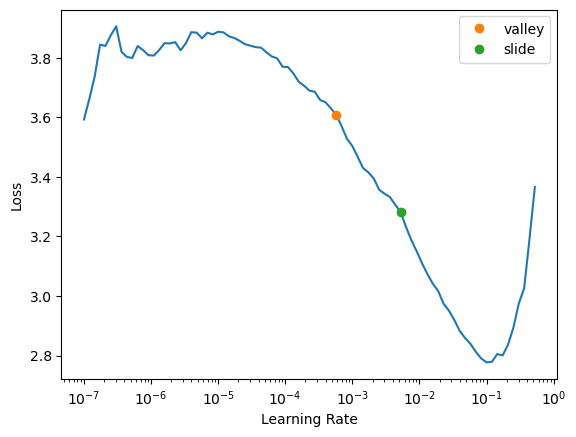

In [ ]:
learn.lr_find(suggest_funcs=(valley, slide))

In [ ]:
# %debug

`lr_find` generally recommends rather conservative learning rates, to ensure that your model will train successfully. I generally like to push it a bit higher if I can. Let's train a few epochs and see how it looks:

### The performance

In [ ]:
learn.fine_tune(3, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,2.696553,3.711585,0.680000,01:26


epoch,train_loss,valid_loss,error_rate,time
0,1.803938,1.855994,0.460000,01:42
1,1.604452,1.686167,0.475000,01:43
2,1.489170,1.564310,0.435000,01:29


In [ ]:
learn.fine_tune(7, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.134716,1.749994,0.485000,01:22


epoch,train_loss,valid_loss,error_rate,time
0,1.147326,1.477777,0.410000,01:47
1,1.032612,1.476066,0.430000,01:46
2,1.005085,1.342792,0.365000,01:52
3,0.911426,1.308911,0.370000,01:47
4,0.838643,1.223818,0.320000,01:46
5,0.763917,1.181947,0.330000,01:49
6,0.703434,1.189888,0.335000,01:45


### ht: learner - save model with `learn.export`

### doc: learn.export(fname='export.pkl', pickle_module=pickle, pickle_protocol=2)

return: nothing, but saved a model as a pkl file in `learn.path` with the name given by `fname`

we can change the folder for storing model by changing `learn.path`

we can give a detailed name to specify the model

```python
@patch
def export(self:Learner, fname='export.pkl', pickle_module=pickle, pickle_protocol=2):
    "Export the content of `self` without the items and the optimizer state for inference"
    if rank_distrib(): return # don't export if child proc
    self._end_cleanup()
    old_dbunch = self.dls
    self.dls = self.dls.new_empty()
    state = self.opt.state_dict() if self.opt is not None else None
    self.opt = None
    with warnings.catch_warnings():
        #To avoid the warning that come from PyTorch about model not being checked
        warnings.simplefilter("ignore")
        # the folder is defined by self.path
        torch.save(self, self.path/fname, pickle_module=pickle_module, pickle_protocol=pickle_protocol)
    self.create_opt()
    if state is not None: self.opt.load_state_dict(state)
    self.dls = old_dbunch
# File:      ~/mambaforge/lib/python3.9/site-packages/fastai/learner.py
# Type:      method
```

In [ ]:
learn.path

Path('.')

In [ ]:
learn.path = Path('models')

In [ ]:
learn.path

Path('models')

In [ ]:
learn.export("paddy_10pct_resnet26d_10epochs.pkl")

### qt: How many epochs should I train in general in this early stage with 10% dataset without gpu

### The result with full dataset on Kaggle

When given the full dataset for training on kaggle, we will have the following

```
epoch	train_loss	valid_loss	error_rate	time
0	1.777575	1.239618	0.397886	01:43
epoch	train_loss	valid_loss	error_rate	time
0	1.161161	0.735699	0.253724	01:46
1	0.774501	0.440555	0.151370	01:47
2	0.543375	0.357847	0.113888	01:46
```

### qt: how to display video and embed webpage

In [ ]:
from IPython.display import display, HTML, IFrame
display(IFrame("https://www.youtube.com/embed/NnTvZWp5Q7o", width="100%", height=200))
display(IFrame("https://www.kaggle.com/embed/jhoward/first-steps-road-to-the-top-part-1?cellIds=24&kernelSessionId=98743415", width="100%", height=200))
display(HTML('<iframe src="https://www.kaggle.com/embed/jhoward/first-steps-road-to-the-top-part-1?cellIds=24&kernelSessionId=98743415" height="300" style="margin: 0 auto; width: 100%; max-width: 950px;" frameborder="0" scrolling="auto" title="First Steps: Road to the Top, Part 1"></iframe>'))

We're now ready to build our first submission. Let's take a look at the sample Kaggle provided to see what it needs to look like:

## Submitting to Kaggle

### how to check the kaggle submission sample csv file

In [ ]:
ss = pd.read_csv(path/'sample_submission.csv')
ss

### how to sort the files in the test set in the alphabetical order; how to create dataloaders for the test set based on the dataloaders of the training set

OK so we need a CSV containing all the test images, in alphabetical order, and the predicted label for each one. We can create the needed test set using fastai like so:

In [ ]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = dls.test_dl(tst_files)

### how to make predictions for all test set; and what does `learn.get_preds` return

We can now get the probabilities of each class, and the index of the most likely class, from this test set (the 2nd thing returned by `get_preds` are the targets, which are blank for a test set, so we discard them):

In [ ]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
idxs

### how to access all the classes of labels with dataloaders

These need to be mapped to the names of each of these diseases, these names are stored by fastai automatically in the `vocab`:

In [ ]:
dls.vocab

### how to map classes to each idx from the predictions

We can create an apply this mapping using pandas:

In [ ]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
results

### how to save result into csv file

Kaggle expects the submission as a CSV file, so let's save it, and check the first few lines:

In [ ]:
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

### how to submit to kaggle with fastkaggle api

Let's submit this to kaggle. We can do it from the notebook if we're running on Kaggle, otherwise we can use the API:

In [ ]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', 'initial rn26d 128px', comp)

Success! We successfully created a submission.

## Conclusion

### what is the most important thing for your first model

Our initial submission is not very good (top 80% of teams) but it only took a minute to train. The important thing is that we have a good starting point to iterate from, and we can do rapid iterations. Every step from loading the data to creating the model to submitting to Kaggle is all automated and runs quickly.

Therefore, we can now try lots of things quickly and easily and use those experiments to improve our results. In the next notebook, we'll do exactly that!

If you found this notebook useful, please remember to click the little up-arrow at the top to upvote it, since I like to know when people have found my work useful, and it helps others find it too. And if you have any questions or comments, please pop them below -- I read every comment I receive!

## Addendum

### ht: kaggle - push notebook

`fastkaggle` also provides a function that pushes a notebook to Kaggle Notebooks. I wrote this notebook on my own machine, and pushed it to Kaggle from there -- here's the command I used:

In [ ]:
nb_name()

```python
def nb_meta(user, id, title, file, competition=None, private=True, gpu=False, internet=True):
    "Get the `dict` required for a kernel-metadata.json file"
    d = {
      "id": f"{user}/{id}",
      "title": title,
      "code_file": file,
      "language": "python",
      "kernel_type": "notebook",
      "is_private": private,
      "enable_gpu": gpu,
      "enable_internet": internet,
      "keywords": [],
      "dataset_sources": [],
      "kernel_sources": []
    }
    if competition: d["competition_sources"] = [f"competitions/{competition}"]
    return d
# File:      ~/mambaforge/lib/python3.9/site-packages/fastkaggle/core.py
# Type:      function
```

```python
def push_notebook(user, id, title, file, path='.', competition=None, private=True, gpu=False, internet=True):
    "Push notebook `file` to Kaggle Notebooks"
    meta = nb_meta(user, id, title, file=file, competition=competition, private=private, gpu=gpu, internet=internet)
    path = Path(path)
    nm = 'kernel-metadata.json'
    path.mkdir(exist_ok=True, parents=True)
    with open(path/nm, 'w') as f: json.dump(meta, f, indent=2)
    api = import_kaggle()
    api.kernels_push_cli(str(path))
# File:      ~/mambaforge/lib/python3.9/site-packages/fastkaggle/core.py
# Type:      function
```

In [ ]:
if not iskaggle:
    push_notebook('danielliao', '0008_fastai_first_steps_road_to_top_part_1',
                  title='0008 fastai first steps 1 version 2',
                  file='0008_fastai_first_steps_road_to_top_part_1.ipynb',
                  competition=comp, private=False, gpu=True)